In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle

from pathlib import Path
from geopy.geocoders import Nominatim

path = Path(r'C:\Users\40732\Desktop\jupyter\COVID')

In [2]:
# Scrub the counties to element the descriptor, which is not standard accross sources

def county_scrub(series):
    
    replace_list = [' County', ' Municipio', ' Parish', ' City and Borough', 'City and Borough of ',' Borough/city',  ' Borough/municipality',
                 ' Municipality', 'Municipality of ', ' Borough', ' Census Area', ' (including other portions of Kansas City)']
    replace_with_list = ['','','']
    series = series.replace(replace_list, '')
    
    return series

In [3]:
#Pull in lat/long for the cities
with open(path/'geo_dict.pkl', 'rb') as f:
    us_state_abbrev, us_state_flip, ll_dict, ll_aqi_dict = pickle.load(f)
    
#Get dates of latest data updates
dates = pd.read_csv(path/'var_dates.csv', index_col=[0])

# Date_parse not working so...
for col in dates.columns:
    dates[col] = pd.to_datetime(dates[col])

dates

,Covid,BLS,Weekly,Los
0,2020-05-18 09:19:10.132802,2020-03-01,2020-05-12,2020-05-06


#### Forecast models

In [4]:
# Los Alamos forecast

now = datetime.today()
los_url = 'https://covid-19.bsvgateway.org/forecast/us/files/'
los_url2 = '/confirmed/'
los_url3 = '_confirmed_quantiles_us_website.csv'

#check if updates to forecast
for date in [datetime.strftime(now - timedelta(days), '%Y-%m-%d') 
             for days in range(max((now-dates.Los[0]).days, 2))]:
    print(date)
    try:
        los = pd.read_csv(los_url + date + los_url2 + date + los_url3)
        dates.Los[0] = datetime.strptime(los.iloc[0,-1], '%Y-%m-%d')
        break
    except:
        pass
    

los.drop(['simple_state', 'q.01', 'q.05', 'q.10', 'q.15','q.20', 'q.25', 'q.30', 'q.35', 
          'q.40', 'q.45','q.55', 'q.60', 'q.65', 'q.70', 'q.75', 'q.80', 'q.85', 'q.90', 
          'q.95', 'q.99', 'obs', 'truth_confirmed'], 
        axis=1, inplace=True)

los.columns = ['Date', 'Lower', 'Case forecast', 'Upper', 'State', 'Forecast date']

los.head()

2020-05-18
2020-05-17
2020-05-16
2020-05-15
2020-05-14
2020-05-13


,Date,Lower,Case forecast,Upper,State,Forecast date
0,2020-03-09,0.0,0.0,0.0,Alabama,2020-05-13
1,2020-03-09,0.0,0.0,0.0,Alaska,2020-05-13
2,2020-03-09,0.0,0.0,0.0,Arizona,2020-05-13
3,2020-03-09,0.0,0.0,0.0,Arkansas,2020-05-13
4,2020-03-09,0.0,0.0,0.0,California,2020-05-13


In [5]:
# Saving the timestamps
dates.to_csv(path/'var_dates.csv')

In [7]:
# Columbia projections
# Honestly not great, for states with looser restriction predicts an exponential rise (as if they wouldn't react to that)

def get_col_proj(file = 'Projection_80contact.csv'):
    

    col_url = 'https://raw.githubusercontent.com/shaman-lab/COVID-19Projection/master/Production/'

    df = pd.read_csv(col_url+file)

    df['fips'] = df['fips'].astype(str).str.zfill(5)

    temp = df['county']
    df.drop(['county', 'report_25', 'report_75', 'total_25', 'total_75' ], axis=1, inplace=True)

    df['County'] = county_scrub(temp.apply(lambda x: x[:-3]))
    df['State'] = temp.apply(lambda x: us_state_flip.get(x[-2:], np.nan))

    df.columns = ['fips', 'Date', 'New cases-lower', 'New cases-forecast', 'New cases-upper', 
                        'Total cases-lower', 'Total cases-forecast', 'Total cases-upper', 'County', 'State']
    return df

diff_proj = ['Projection_80contact.csv', 'Projection_80xcontact.csv', 'Projection_80wcontact.csv']

'''
# Use this code for all three forecasts

col_proj = {}
for i, proj in enumerate(diff_proj):
    ind = diff_proj[i][13]
    col_proj[ind] = get_col_proj(diff_proj[i])
    col_proj[ind].index = col_proj[ind]['fips'] + '|' + col_proj[ind]['Date'] + '|' + col_proj[ind]['County'] + '|' + col_proj[ind]['State']
    col_proj[ind].drop(['fips', 'Date', 'County', 'State'], axis=1, inplace=True)

    
proj = pd.concat(col_proj.values(), axis=1, keys=col_proj.keys()).reset_index()
temp = proj['index'].str.split('|')


proj['fips'] = temp.apply(lambda x: x[0])
proj['Date'] = temp.apply(lambda x: x[1])
proj['County'] = temp.apply(lambda x: x[2])
proj['State'] = temp.apply(lambda x: x[3])

proj.columns = [' '.join(col).strip() for col in proj.columns.values]
proj.drop('index', axis=1).to_csv(path/'columbia_forecasts.csv')

proj.head()

'''

''
#get_col_proj().to_csv(path/'columbia_forecasts.csv')

"\n# Use this code for all three forecasts\n\ncol_proj = {}\nfor i, proj in enumerate(diff_proj):\n    ind = diff_proj[i][13]\n    col_proj[ind] = get_col_proj(diff_proj[i])\n    col_proj[ind].index = col_proj[ind]['fips'] + '|' + col_proj[ind]['Date'] + '|' + col_proj[ind]['County'] + '|' + col_proj[ind]['State']\n    col_proj[ind].drop(['fips', 'Date', 'County', 'State'], axis=1, inplace=True)\n\n    \nproj = pd.concat(col_proj.values(), axis=1, keys=col_proj.keys()).reset_index()\ntemp = proj['index'].str.split('|')\n\n\nproj['fips'] = temp.apply(lambda x: x[0])\nproj['Date'] = temp.apply(lambda x: x[1])\nproj['County'] = temp.apply(lambda x: x[2])\nproj['State'] = temp.apply(lambda x: x[3])\n\nproj.columns = [' '.join(col).strip() for col in proj.columns.values]\nproj.drop('index', axis=1).to_csv(path/'columbia_forecasts.csv')\n\nproj.head()\n\n"

In [8]:
# CDC combination and forecast

cdc = pd.read_csv('https://www.cdc.gov/coronavirus/2019-ncov/covid-data/files/2020-05-04-model-data.csv')

cdc.columns = ['Model', 'Forecast date', 'target', 'Date', 'State', 'Death forecast', 'Lower', 'Upper']

# Convert target string to date
base_date = datetime(2020, 5, 2)
cdc['Date'] = cdc.target.apply(lambda x: datetime(2020, 5, 2) + timedelta(weeks=int(x.split(' wk')[0])))
cdc = cdc.drop('target', axis=1).drop(cdc[cdc['State'].str.len() == 2].index)

cdc = cdc.append(cdc[cdc['State'] != 'National'].groupby(['Model', 'Date'])['Death forecast', 'Lower', 'Upper']
           .sum().reset_index(),ignore_index=True).fillna({'Forecast date':'2020-05-04', 'State':'National'})
cdc.tail()


C:\ML\envs\HDS-env\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


,Model,Forecast date,Date,State,Death forecast,Lower,Upper
6117,YYG-ParamSearch,2020-05-04,2020-06-13,National,123694,91720.0,167680.0
6118,YYG-ParamSearch,2020-05-04,2020-06-20,National,129547,92680.0,182649.0
6119,YYG-ParamSearch,2020-05-04,2020-06-27,National,135416,93488.0,198352.0
6120,YYG-ParamSearch,2020-05-04,2020-07-04,National,141471,94174.0,215679.0
6121,YYG-ParamSearch,2020-05-04,2020-07-11,National,147549,94683.0,234533.0


In [9]:
cdc.to_csv(path/'model_ensemble.csv')

In [10]:
cdc.append(cdc[cdc['State'] != 'National'].groupby(['Model', 'Date'])['Death forecast', 'Lower', 'Upper']
           .sum().reset_index(),ignore_index=True).fillna({'Forecast date':'2020-05-04', 'State':'National'})


C:\ML\envs\HDS-env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Model,Forecast date,Date,State,Death forecast,Lower,Upper
0,COVIDhub-ensemble,2020-05-04,2020-05-09,Alabama,351,319.0,426.0
1,COVIDhub-ensemble,2020-05-04,2020-05-09,Alaska,11,11.0,15.0
2,COVIDhub-ensemble,2020-05-04,2020-05-09,Arizona,432,396.0,502.0
3,COVIDhub-ensemble,2020-05-04,2020-05-09,Arkansas,89,79.0,115.0
4,COVIDhub-ensemble,2020-05-04,2020-05-09,California,2708,2513.0,3045.0
...,...,...,...,...,...,...,...
6214,YYG-ParamSearch,2020-05-04,2020-06-13,National,123694,91720.0,167680.0
6215,YYG-ParamSearch,2020-05-04,2020-06-20,National,129547,92680.0,182649.0
6216,YYG-ParamSearch,2020-05-04,2020-06-27,National,135416,93488.0,198352.0
6217,YYG-ParamSearch,2020-05-04,2020-07-04,National,141471,94174.0,215679.0


#### Geo data

In [11]:
#get lat/longs for the cities
geolocator = Nominatim(user_agent='Apple Mobility')

def get_latlong(city_list):
    ll = []
    for d in city_list:
        temp = geolocator.geocode(d)
        ll.append([temp.latitude, temp.longitude])
    return ll

#List of the apple data cities
dict_city = {'New York City': 'NY', 'Baltimore':'MD', 'Boston':'MA', 'San Francisco - Bay Area':'CA', 'Chicago':'IL', 'Dallas':'TX', 'Seattle':'WA', 'Houston':'TX',
             'Detroit':'MI', 'Miami':'FL', 'Atlanta':'GA','United States':'USA', 'Washington DC':'DC', 'Denver':'CO', 'Philadelphia':'PA'}

# List of cities with air quality data
aqi_cities = ['Milwaukee', 'Las Vegas', 'Denver', 'Jacksonville', 'Albuquerque',
       'Saint Paul', 'Boise', 'Tucson', 'San Jose', 'Phoenix', 'Los Angeles',
       'Oklahoma City', 'Portland', 'Fresno', 'Chicago', 'Staten Island',
       'Raleigh', 'Washington D.C.', 'Hartford', 'Atlanta', 'Miami', 'Seattle',
       'Indianapolis', 'Philadelphia', 'El Paso', 'Manhattan', 'San Francisco',
       'Queens', 'The Bronx', 'Brooklyn', 'Oakland', 'Boston', 'Honolulu',
       'Baltimore', 'Jackson', 'Tallahassee', 'Madison', 'Salt Lake City',
       'Detroit', 'Providence', 'Omaha', 'Richmond', 'Columbus', 'Sacramento',
       'Charlotte', 'Houston', 'Dallas', 'Memphis', 'Nashville', 'San Antonio',
       'Little Rock', 'Fort Worth', 'Springfield', 'Austin', 'Salem',
       'Columbia', 'San Diego']

#Run to get latitude and longitude of cities
#ll_dict = dict(zip(dict_city.keys(), get_latlong(list(dict_city.keys()))))
#ll_aqi_dict = dict(zip(aqi_cities, get_latlong(aqi_cities)))
# drop into pickle

r'''
with open(path/'geo_dict.pkl', 'wb') as f:
    pickle.dump([us_state_abbrev, us_state_flip, ll_dict, ll_aqi_dict], f)
'''

"\nwith open(path/'geo_dict.pkl', 'wb') as f:\n    pickle.dump([us_state_abbrev, us_state_flip, ll_dict, ll_aqi_dict], f)\n"

#### CMU COVID hotspot func

In [12]:
# CMU coverage, shows potential hotspots of COVID

def get_cmu_data(start_date = '20200425', end_date = 'today', data_source = 'fb-survey', 
                 time_type = 'day', signal = 'raw_cli', geo_type = 'county', geo_value = '*'):
    #reomve dashes and turn to string
    start_date = str(start_date).replace('-','')
    end_date = str(end_date).replace('-','')
    
    if end_date == 'today':
        end_date = str(20200000 + datetime.today().month*100 + datetime.today().day)

    
    time_values = start_date + '-' + end_date
    cm_url = r'https://delphi.cmu.edu/epidata/api.php'

    r_url = cm_url + '?source=covidcast&data_source=' + data_source + '&signal=' + signal + '&time_type=' \
    + time_type + '&geo_type=' + geo_type + '&time_values=' + time_values + '&geo_value=' + geo_value
    r_cm = requests.get(r_url)

    return r_cm.json()
    

#### Google mobility

,State,County,iso,fips,Date,Retail_recreation,Grocery_pharmacy,Parks,Transit,Workplace,Residential,State only,Full USA
351533,Minnesota,Pipestone County,NaN,27117.0,2020-05-25,NaN,NaN,NaN,NaN,-70.0,NaN,False,False
256843,Georgia,Gwinnett County,NaN,13135.0,2020-03-11,3.0,8.0,53.0,-1.0,0.0,0.0,False,False
307000,Kansas,Linn County,NaN,20107.0,2020-04-28,NaN,NaN,NaN,NaN,-32.0,NaN,False,False
416489,Ohio,Erie County,NaN,39043.0,2020-04-24,-35.0,-12.0,NaN,-9.0,-43.0,18.0,False,False
262253,Georgia,Polk County,NaN,13233.0,2020-03-17,-7.0,15.0,NaN,NaN,-16.0,6.0,False,False
392387,New Mexico,Valencia County,NaN,35061.0,2020-02-28,13.0,18.0,10.0,21.0,6.0,-2.0,False,False
408366,North Carolina,Pitt County,NaN,37147.0,2020-03-15,-11.0,10.0,-23.0,NaN,-6.0,3.0,False,False
329070,Louisiana,West Feliciana Parish,NaN,22125.0,2020-06-03,NaN,NaN,NaN,NaN,-38.0,NaN,False,False
369578,Missouri,McDonald County,NaN,29119.0,2020-06-05,NaN,NaN,NaN,NaN,-24.0,NaN,False,False
226047,Arkansas,Prairie County,NaN,5117.0,2020-04-22,NaN,NaN,NaN,NaN,-18.0,NaN,False,False


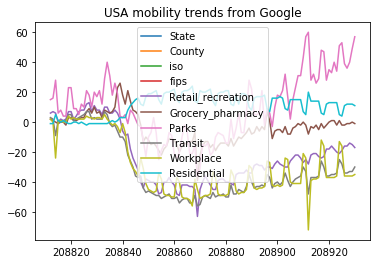

In [7]:
#Google data now comes in csv

goog = pd.read_csv(r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', low_memory=False)

goog = goog[goog['country_region_code'] == 'US'].drop(['country_region_code', 'country_region'], axis=1)

goog.columns = ['State', 'County', 'iso', 'fips', 'Date', 'Retail_recreation', 'Grocery_pharmacy', 'Parks', 'Transit', 'Workplace', 'Residential']

goog.loc[:, 'County'] = county_scrub(goog[['County']])
goog['State only'] = (goog['County'].isna()) & ~(goog['State'].isna())
goog['Full USA'] = (goog['County'].isna()) & (goog['State'].isna())
goog[goog['Full USA'] == True].plot(title='USA mobility trends from Google')
goog['Date'] = pd.to_datetime(goog['Date'])
goog.to_csv(path/'google_mobility.csv')

goog.sample(10)

In [6]:
goog.sample(10)

,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
409477,North Carolina,Scotland County,NaN,37165.0,2020-04-24,-16.0,-6.0,NaN,NaN,-32.0,NaN
359617,Mississippi,Newton County,NaN,28101.0,2020-02-20,-14.0,-8.0,NaN,NaN,3.0,NaN
236692,Colorado,Gilpin County,NaN,8047.0,2020-05-29,NaN,NaN,NaN,NaN,-51.0,NaN
220478,Arkansas,Benton County,NaN,5007.0,2020-06-01,-7.0,3.0,150.0,-45.0,-42.0,13.0
312400,Kentucky,Campbell County,NaN,21037.0,2020-05-01,-33.0,-3.0,NaN,NaN,-51.0,20.0
311874,Kentucky,Breckinridge County,NaN,21027.0,2020-06-11,NaN,NaN,NaN,NaN,-23.0,NaN
227667,Arkansas,Yell County,NaN,5149.0,2020-03-02,18.0,12.0,NaN,NaN,5.0,NaN
347979,Minnesota,Goodhue County,NaN,27049.0,2020-02-24,2.0,-4.0,NaN,NaN,-2.0,0.0
274233,Illinois,Franklin County,NaN,17055.0,2020-05-04,NaN,NaN,NaN,NaN,-33.0,10.0
393898,New York,Columbia County,NaN,36021.0,2020-05-21,-27.0,22.0,NaN,6.0,-37.0,12.0


#### Air quality

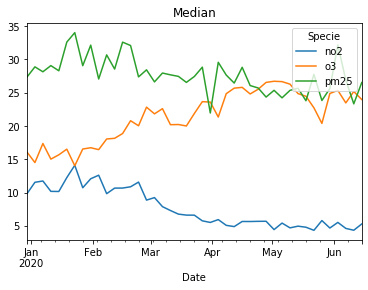

NameError: name 'll_aqi_dict' is not defined

In [3]:
#download air quality info
df_air = pd.read_csv(r'https://aqicn.org/data-platform/covid19/report/10302-2a9d43de/2020', header=[4])

# Look at trends since January, shows that NO2 best predictor
df_air['Date'] = pd.to_datetime(df_air.Date)
pol = ['no2', 'o3', 'pm25']

bol = (df_air['Country'] == 'US') & (df_air['Specie'].isin(pol))
df_air[bol].pivot_table(index='Date', columns='Specie', values='median').resample('4d').mean().plot();
plt.title('Median');
plt.show()


pol = ['no2']
bol = (df_air['Country'] == 'US') & (df_air['Specie'].isin(pol))
df_usair = df_air[bol].pivot_table(index=['Date', 'City'], columns='Specie', values='median').reset_index()
df_usair.columns = ['Date', 'City', 'Median NO2']
df_usair['Latitude'] = df_usair['City'].apply(lambda x: ll_aqi_dict[x][0])
df_usair['Longitude'] = df_usair['City'].apply(lambda x: ll_aqi_dict[x][1])
df_usair.to_csv(path/'us_aqi.csv')

df_usair.head()